# 학습 방법 - Scene

3개의 Scene에 대해서 각각 따로 학습

user별로 학습을 하지 않는 이유는 상관관계로 보았을 때 user끼리는 달라도 scene별로는 유사점이 꽤 보였기 때문.

In [2]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset
import pandas as pd
import random

import torch_burn as tb
import utils

In [3]:
EXPERIMENT_NAME = 'Scene3-LSTM[SmallWindow]'
CHECKPOINT_DIR = Path('checkpoint', EXPERIMENT_NAME)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('data/1116')
TRAIN_FILES = sorted(list(DATA_DIR.glob('*scene3_0.csv')))
TEST_FILES = sorted(list(DATA_DIR.glob('*scene3_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [5]:
WINDOW_SIZE = 48

In [6]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile,
                 window_size=300, randomized_window_size=False,
                 stride=30, randomized_stride=False):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size

        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            if randomized_window_size:
                self.indexes.append((i, i + random.randint(window_size // 2, window_size)))
            else:
                self.indexes.append((i, i + window_size))

            if randomized_stride:
                i += random.randint(1, stride)
            else:
                i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        s, t = self.indexes[idx]
        x = self.csv.iloc[s:t][self.xcols].to_numpy()
        y = self.csv.iloc[t + 6][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 3
        
        #x[:, :3] *= pi / 180
        x[:, 3:] /= 10

        return x, y

In [7]:
ds_train = [CSVSequentialDataset(f,  
                                 window_size=WINDOW_SIZE, randomized_window_size=False,
                                 stride=5, randomized_stride=True) for f in TRAIN_FILES]
ds_train = tb.data.ChainDataset(*ds_train)
ds_test = [CSVSequentialDataset(f,  
                                window_size=WINDOW_SIZE, randomized_window_size=False,
                                stride=5, randomized_stride=True) for f in TEST_FILES]
ds_test = tb.data.ChainDataset(*ds_test)

In [8]:
len(ds_train), len(ds_test)

(18776, 18173)

In [9]:
ds_train[0][0].shape, ds_train[0][1].shape

(torch.Size([48, 6]), torch.Size([3]))

In [10]:
x, y = ds_train[0]

In [11]:
x.shape

torch.Size([48, 6])

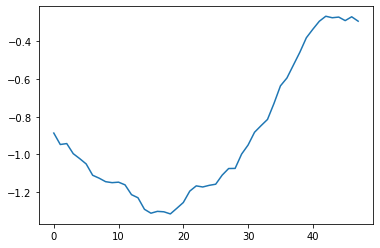

In [12]:
plt.plot(x[:, 2])

# 모델 생성

StackedLSTM Bidirectional

In [13]:
model = utils.BaselineLSTM(input_size=6,
                           hidden_size=64,
                           num_layers=8,
                           dropout=0.2,
                           bidirectional=True).cuda()

In [14]:
criterion = nn.MSELoss().cuda()
optimizer = torch_optimizer.RAdam(model.parameters())

In [15]:
metrics = [tb.metrics.ModuleMetric(criterion, 'loss'),
           utils.HPMetric('hp_metric'),
           utils.HPSignalHistory(CHECKPOINT_DIR / 'sample' / '{epoch:04d}.npy', 'hp_signal')]

In [16]:
callbacks = [tb.callbacks.EarlyStopping(metrics[0]),
             tb.callbacks.LRDecaying(optimizer, metrics[0])]

In [17]:
trainer = tb.Trainer(model, optimizer, metrics, callbacks, ncols=100)

In [18]:
trainer.fit(ds_train, ds_test, num_epochs=100, batch_size=256, shuffle=True, pin_memory=True)

[0002/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :  18.657024
 - Pitch        :  10.347923
 - Roll         :   2.549479
 - RMS          :  12.405159
 - 99% Tile     :  43.301153
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0001.npy


[0003/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :  15.372462
 - Pitch        :   9.268257
 - Roll         :   2.427434
 - RMS          :  10.457941
 - 99% Tile     :  39.800809
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0002.npy


[0004/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :  12.107818
 - Pitch        :   8.504319
 - Roll         :   2.348278
 - RMS          :   8.649414
 - 99% Tile     :  34.067908
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0003.npy


[0005/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.792017
 - Pitch        :   7.896944
 - Roll         :   2.376457
 - RMS          :   7.391275
 - 99% Tile     :  30.726315
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0004.npy


[0006/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   8.158566
 - Pitch        :   7.523151
 - Roll         :   2.391824
 - RMS          :   6.554409
 - 99% Tile     :  28.097508
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0005.npy


[0007/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   7.102384
 - Pitch        :   7.198709
 - Roll         :   2.353718
 - RMS          :   5.994588
 - 99% Tile     :  26.110166
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0006.npy


[0008/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   6.301021
 - Pitch        :   6.859622
 - Roll         :   2.381082
 - RMS          :   5.550581
 - 99% Tile     :  24.196860
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0007.npy


[0009/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   5.574839
 - Pitch        :   6.807947
 - Roll         :   2.336484
 - RMS          :   5.256302
 - 99% Tile     :  22.397871
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0008.npy


[0010/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.804441
 - Pitch        :   6.760334
 - Roll         :   2.347136
 - RMS          :   4.976405
 - 99% Tile     :  21.295212
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0009.npy


[0011/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.094948
 - Pitch        :   6.962294
 - Roll         :   2.348742
 - RMS          :   4.856567
 - 99% Tile     :  21.438778
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0010.npy


[0012/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.171532
 - Pitch        :   6.340932
 - Roll         :   2.326788
 - RMS          :   4.583414
 - 99% Tile     :  21.144928
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0011.npy


[0013/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.144959
 - Pitch        :   4.616970
 - Roll         :   2.359386
 - RMS          :   3.501137
 - 99% Tile     :  17.103890
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0012.npy


[0014/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.553551
 - Pitch        :   3.123868
 - Roll         :   2.321198
 - RMS          :   2.687448
 - 99% Tile     :  12.771628
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0013.npy


[0015/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.158494
 - Pitch        :   2.490856
 - Roll         :   2.307254
 - RMS          :   2.322849
 - 99% Tile     :  11.620359
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0014.npy


[0016/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.003247
 - Pitch        :   2.152582
 - Roll         :   2.346044
 - RMS          :   2.171830
 - 99% Tile     :  11.136327
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0015.npy


[0017/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.819786
 - Pitch        :   1.782557
 - Roll         :   2.265286
 - RMS          :   1.968134
 - 99% Tile     :  10.348979
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0016.npy


[0018/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.636762
 - Pitch        :   1.920684
 - Roll         :   2.285808
 - RMS          :   1.965785
 - 99% Tile     :   9.870632
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0017.npy


[0019/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.066276
 - Pitch        :   1.535218
 - Roll         :   2.220634
 - RMS          :   1.962788
 - 99% Tile     :   9.276152
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0018.npy


[0020/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.672905
 - Pitch        :   1.507742
 - Roll         :   2.217508
 - RMS          :   1.824759
 - 99% Tile     :   8.895488
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0019.npy


[0021/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.581057
 - Pitch        :   1.481624
 - Roll         :   2.237247
 - RMS          :   1.798168
 - 99% Tile     :   8.430956
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0020.npy


[0022/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.506729
 - Pitch        :   1.414325
 - Roll         :   2.213644
 - RMS          :   1.748406
 - 99% Tile     :   8.106254
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0021.npy


[0023/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.366381
 - Pitch        :   1.382940
 - Roll         :   2.200461
 - RMS          :   1.695243
 - 99% Tile     :   7.840205
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0022.npy


[0024/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.451229
 - Pitch        :   1.397676
 - Roll         :   2.213792
 - RMS          :   1.728240
 - 99% Tile     :   7.691647
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0023.npy


[0025/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.271164
 - Pitch        :   1.271127
 - Roll         :   2.194082
 - RMS          :   1.637643
 - 99% Tile     :   7.364565
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0024.npy


[0026/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.309641
 - Pitch        :   1.142182
 - Roll         :   2.242883
 - RMS          :   1.638115
 - 99% Tile     :   7.305435
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0025.npy


[0027/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.200936
 - Pitch        :   1.256670
 - Roll         :   2.219450
 - RMS          :   1.627619
 - 99% Tile     :   7.036585
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0026.npy


[0028/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.236510
 - Pitch        :   1.287341
 - Roll         :   2.232669
 - RMS          :   1.650355
 - 99% Tile     :   7.229449
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0027.npy


[0029/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.190417
 - Pitch        :   1.272275
 - Roll         :   2.185264
 - RMS          :   1.613604
 - 99% Tile     :   7.050668
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0028.npy


[0030/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.153668
 - Pitch        :   1.097777
 - Roll         :   2.199494
 - RMS          :   1.567784
 - 99% Tile     :   7.032257
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0029.npy


[0031/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.430911
 - Pitch        :   1.139351
 - Roll         :   2.220096
 - RMS          :   1.660768
 - 99% Tile     :   6.884807
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0030.npy


[0032/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.473477
 - Pitch        :   1.050611
 - Roll         :   2.216669
 - RMS          :   1.652124
 - 99% Tile     :   7.172447
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0031.npy


[0033/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.017855
 - Pitch        :   1.066937
 - Roll         :   2.251897
 - RMS          :   1.554072
 - 99% Tile     :   7.147570
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0032.npy


[0034/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.141011
 - Pitch        :   1.213261
 - Roll         :   2.280774
 - RMS          :   1.630525
 - 99% Tile     :   7.044689
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0033.npy


[0035/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.116527
 - Pitch        :   1.058944
 - Roll         :   2.244673
 - RMS          :   1.571258
 - 99% Tile     :   6.993931
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0034.npy


[0036/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.155008
 - Pitch        :   1.066196
 - Roll         :   2.282873
 - RMS          :   1.600242
 - 99% Tile     :   7.059618
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0035.npy


[0037/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.271811
 - Pitch        :   1.151238
 - Roll         :   2.249891
 - RMS          :   1.633489
 - 99% Tile     :   6.948073
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0036.npy


[0038/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.080924
 - Pitch        :   1.143705
 - Roll         :   2.271385
 - RMS          :   1.595373
 - 99% Tile     :   6.917733
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0037.npy


[0039/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.189855
 - Pitch        :   1.086951
 - Roll         :   2.180058
 - RMS          :   1.565234
 - 99% Tile     :   7.004712
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0038.npy


[0040/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.232175
 - Pitch        :   1.122449
 - Roll         :   2.180423
 - RMS          :   1.584550
 - 99% Tile     :   6.990085
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0039.npy


[0041/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.730190
 - Pitch        :   1.144918
 - Roll         :   2.174597
 - RMS          :   1.735249
 - 99% Tile     :   6.909418
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0040.npy


[0042/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.109608
 - Pitch        :   1.095487
 - Roll         :   2.218014
 - RMS          :   1.565344
 - 99% Tile     :   7.112229
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0041.npy


[0043/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.103003
 - Pitch        :   1.101085
 - Roll         :   2.240671
 - RMS          :   1.575818
 - 99% Tile     :   7.240340
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0042.npy


[0044/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

Decaying lr from 0.001 to 0.0005 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.297274
 - Pitch        :   1.056978
 - Roll         :   2.215006
 - RMS          :   1.602745
 - 99% Tile     :   7.281228
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0043.npy


[0045/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.183290
 - Pitch        :   1.025183
 - Roll         :   2.224020
 - RMS          :   1.570291
 - 99% Tile     :   7.038891
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0044.npy


[0046/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.015394
 - Pitch        :   1.058552
 - Roll         :   2.182094
 - RMS          :   1.518013
 - 99% Tile     :   6.994103
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0045.npy


[0047/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.056766
 - Pitch        :   1.054690
 - Roll         :   2.205538
 - RMS          :   1.537696
 - 99% Tile     :   7.054629
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0046.npy


[0048/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.065124
 - Pitch        :   1.050924
 - Roll         :   2.157078
 - RMS          :   1.515686
 - 99% Tile     :   7.025193
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0047.npy


[0049/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.205810
 - Pitch        :   1.019416
 - Roll         :   2.146758
 - RMS          :   1.538588
 - 99% Tile     :   6.751818
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0048.npy


[0050/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.080451
 - Pitch        :   1.076563
 - Roll         :   2.102968
 - RMS          :   1.499871
 - 99% Tile     :   6.883824
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0049.npy


[0051/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.469891
 - Pitch        :   1.192977
 - Roll         :   1.849218
 - RMS          :   1.527894
 - 99% Tile     :   6.778427
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0050.npy


[0052/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.214279
 - Pitch        :   1.040736
 - Roll         :   1.598194
 - RMS          :   1.305351
 - 99% Tile     :   6.930208
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0051.npy


[0053/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.166100
 - Pitch        :   1.136936
 - Roll         :   1.323774
 - RMS          :   1.211719
 - 99% Tile     :   6.292738
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0052.npy


[0054/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.173309
 - Pitch        :   0.938421
 - Roll         :   1.173807
 - RMS          :   1.100774
 - 99% Tile     :   6.023238
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0053.npy


[0055/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.249568
 - Pitch        :   0.939517
 - Roll         :   1.150455
 - RMS          :   1.120663
 - 99% Tile     :   5.753278
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0054.npy


[0056/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.095872
 - Pitch        :   0.905406
 - Roll         :   0.941708
 - RMS          :   0.984464
 - 99% Tile     :   5.631296
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0055.npy


[0057/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.252039
 - Pitch        :   0.930799
 - Roll         :   0.854324
 - RMS          :   1.026947
 - 99% Tile     :   5.556359
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0056.npy


[0058/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.110096
 - Pitch        :   0.865522
 - Roll         :   0.821204
 - RMS          :   0.940889
 - 99% Tile     :   5.487868
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0057.npy


[0059/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.203188
 - Pitch        :   0.917065
 - Roll         :   1.046571
 - RMS          :   1.062070
 - 99% Tile     :   5.629373
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0058.npy


[0060/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.114181
 - Pitch        :   0.948372
 - Roll         :   0.809861
 - RMS          :   0.965519
 - 99% Tile     :   5.573282
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0059.npy


[0061/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.062155
 - Pitch        :   0.841279
 - Roll         :   0.764483
 - RMS          :   0.898213
 - 99% Tile     :   5.568189
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0060.npy


[0062/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.968619
 - Pitch        :   1.157787
 - Roll         :   0.835301
 - RMS          :   0.996063
 - 99% Tile     :   5.414684
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0061.npy


[0063/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.004242
 - Pitch        :   0.840536
 - Roll         :   0.736888
 - RMS          :   0.867565
 - 99% Tile     :   5.621723
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0062.npy


[0064/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.015783
 - Pitch        :   0.807327
 - Roll         :   0.687330
 - RMS          :   0.847745
 - 99% Tile     :   5.457969
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0063.npy


[0065/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.043637
 - Pitch        :   0.819781
 - Roll         :   0.656550
 - RMS          :   0.854845
 - 99% Tile     :   5.313033
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0064.npy


[0066/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.058779
 - Pitch        :   0.788345
 - Roll         :   0.647194
 - RMS          :   0.848795
 - 99% Tile     :   5.396605
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0065.npy


[0067/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.031848
 - Pitch        :   0.784795
 - Roll         :   0.634107
 - RMS          :   0.833208
 - 99% Tile     :   5.290892
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0066.npy


[0068/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.107593
 - Pitch        :   0.776395
 - Roll         :   0.624028
 - RMS          :   0.860031
 - 99% Tile     :   5.318757
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0067.npy


[0069/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.943580
 - Pitch        :   0.854269
 - Roll         :   0.669508
 - RMS          :   0.830333
 - 99% Tile     :   5.351672
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0068.npy


[0070/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.024644
 - Pitch        :   0.785854
 - Roll         :   0.620462
 - RMS          :   0.827130
 - 99% Tile     :   5.322841
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0069.npy


[0071/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.041077
 - Pitch        :   0.791538
 - Roll         :   0.730151
 - RMS          :   0.864773
 - 99% Tile     :   5.339110
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0070.npy


[0072/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.960075
 - Pitch        :   0.751599
 - Roll         :   0.665341
 - RMS          :   0.801940
 - 99% Tile     :   5.187988
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0071.npy


[0073/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.964059
 - Pitch        :   0.769185
 - Roll         :   0.632982
 - RMS          :   0.800359
 - 99% Tile     :   5.186886
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0072.npy


[0074/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.010219
 - Pitch        :   0.762247
 - Roll         :   0.598767
 - RMS          :   0.808308
 - 99% Tile     :   5.279568
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0073.npy


[0075/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.961939
 - Pitch        :   0.784699
 - Roll         :   0.593369
 - RMS          :   0.794390
 - 99% Tile     :   5.223886
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0074.npy


[0076/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.026454
 - Pitch        :   0.730765
 - Roll         :   0.617310
 - RMS          :   0.810081
 - 99% Tile     :   5.245778
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0075.npy


[0077/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.086997
 - Pitch        :   0.866684
 - Roll         :   0.579381
 - RMS          :   0.869557
 - 99% Tile     :   5.159582
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0076.npy


[0078/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.898445
 - Pitch        :   0.800316
 - Roll         :   0.612519
 - RMS          :   0.779506
 - 99% Tile     :   5.213444
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0077.npy


[0079/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.922428
 - Pitch        :   0.774228
 - Roll         :   0.573976
 - RMS          :   0.770228
 - 99% Tile     :   5.375920
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0078.npy


[0080/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.926436
 - Pitch        :   0.868243
 - Roll         :   0.566267
 - RMS          :   0.802660
 - 99% Tile     :   5.235766
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0079.npy


[0081/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.918583
 - Pitch        :   0.776701
 - Roll         :   0.560993
 - RMS          :   0.766327
 - 99% Tile     :   5.198105
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0080.npy


[0082/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.918041
 - Pitch        :   0.702837
 - Roll         :   0.599660
 - RMS          :   0.751969
 - 99% Tile     :   5.117170
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0081.npy


[0083/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.018766
 - Pitch        :   0.786901
 - Roll         :   0.601185
 - RMS          :   0.820268
 - 99% Tile     :   5.368444
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0082.npy


[0084/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.967986
 - Pitch        :   0.710982
 - Roll         :   0.592845
 - RMS          :   0.773295
 - 99% Tile     :   5.148663
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0083.npy


[0085/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.957544
 - Pitch        :   0.783356
 - Roll         :   0.557542
 - RMS          :   0.783452
 - 99% Tile     :   5.313729
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0084.npy


[0086/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

Decaying lr from 0.0005 to 0.00025 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.966516
 - Pitch        :   0.720043
 - Roll         :   0.566960
 - RMS          :   0.768995
 - 99% Tile     :   5.159166
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0085.npy


[0087/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.987648
 - Pitch        :   0.721064
 - Roll         :   0.534260
 - RMS          :   0.770458
 - 99% Tile     :   5.106554
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0086.npy


[0088/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.899246
 - Pitch        :   0.698286
 - Roll         :   0.531636
 - RMS          :   0.725461
 - 99% Tile     :   5.145348
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0087.npy


[0089/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.967340
 - Pitch        :   0.705789
 - Roll         :   0.543397
 - RMS          :   0.759203
 - 99% Tile     :   5.203990
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0088.npy


[0090/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.941448
 - Pitch        :   0.695856
 - Roll         :   0.612795
 - RMS          :   0.762902
 - 99% Tile     :   5.118718
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0089.npy


[0091/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.924040
 - Pitch        :   0.708656
 - Roll         :   0.526510
 - RMS          :   0.737847
 - 99% Tile     :   5.278151
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0090.npy


[0092/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.950525
 - Pitch        :   0.685274
 - Roll         :   0.523163
 - RMS          :   0.740900
 - 99% Tile     :   5.268543
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0091.npy


[0093/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

Decaying lr from 0.00025 to 0.000125 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.980902
 - Pitch        :   0.728035
 - Roll         :   0.546695
 - RMS          :   0.772675
 - 99% Tile     :   5.213603
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0092.npy


[0094/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.877807
 - Pitch        :   0.695783
 - Roll         :   0.550385
 - RMS          :   0.720551
 - 99% Tile     :   5.249864
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0093.npy


[0095/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 7 epochs
                  validation
 - Yaw          :   0.887959
 - Pitch        :   0.678174
 - Roll         :   0.518729
 - RMS          :   0.711213
 - 99% Tile     :   5.225448
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0094.npy


[0096/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 8 epochs
                  validation
 - Yaw          :   0.881272
 - Pitch        :   0.681505
 - Roll         :   0.524146
 - RMS          :   0.710825
 - 99% Tile     :   5.226421
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0095.npy


[0097/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 9 epochs
                  validation
 - Yaw          :   0.857526
 - Pitch        :   0.695253
 - Roll         :   0.520396
 - RMS          :   0.704637
 - 99% Tile     :   5.238873
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0096.npy


[0098/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.836532
 - Pitch        :   0.665864
 - Roll         :   0.524844
 - RMS          :   0.687658
 - 99% Tile     :   5.218097
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0097.npy


[0099/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.872260
 - Pitch        :   0.709793
 - Roll         :   0.524942
 - RMS          :   0.716521
 - 99% Tile     :   5.184483
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0098.npy


[0100/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.869272
 - Pitch        :   0.712595
 - Roll         :   0.535496
 - RMS          :   0.718838
 - 99% Tile     :   5.173627
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0099.npy


[0100/0100] Validation: 100%|██████████████████████| 71/71 [00:02<00:00, 29.60it/s, val_loss 1.7645]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.911338
 - Pitch        :   0.678851
 - Roll         :   0.518758
 - RMS          :   0.721223
 - 99% Tile     :   5.168081
Save output signals into checkpoint/Scene3-LSTM[SmallWindow]/sample/0100.npy
